# Sentiment Analysis

### Importing 

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.layers import LSTM,Dense,Embedding
from keras.models import Sequential
import re
import sys
from keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.layers import Flatten
from keras.preprocessing.text import Tokenizer

In [40]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [41]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [42]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [43]:
train.nunique()

id       31962
label        2
tweet    29530
dtype: int64

In [44]:
test.nunique()

id       17197
tweet    16130
dtype: int64

In [45]:
train.isnull().sum()
train.isna().sum()

id       0
label    0
tweet    0
dtype: int64

In [46]:
test.isnull().sum()
test.isna().sum()

id       0
tweet    0
dtype: int64

In [47]:
train.dtypes

id        int64
label     int64
tweet    object
dtype: object

In [48]:
test.dtypes

id        int64
tweet    object
dtype: object

### Preprocessing

In [49]:
train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)

In [50]:
train

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
...,...,...
31957,0,ate @user isz that youuu?ðððððð...
31958,0,to see nina turner on the airwaves trying to...
31959,0,listening to sad songs on a monday morning otw...
31960,1,"@user #sikh #temple vandalised in in #calgary,..."


In [51]:
test

,tweet
0,#studiolife #aislife #requires #passion #dedic...
1,@user #white #supremacists want everyone to s...
2,safe ways to heal your #acne!! #altwaystohe...
3,is the hp and the cursed child book up for res...
4,"3rd #bihday to my amazing, hilarious #nephew..."
...,...
17192,thought factory: left-right polarisation! #tru...
17193,feeling like a mermaid ð #hairflip #neverre...
17194,#hillary #campaigned today in #ohio((omg)) &am...
17195,"happy, at work conference: right mindset leads..."


In [52]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [53]:
token = ToktokTokenizer()

In [54]:
train['tweet']= train['tweet'].apply(lambda a:clean_text(a))
test['tweet']= test['tweet'].apply(lambda a:clean_text(a))

In [55]:
train['tweet'][0]

'@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run'

In [56]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [57]:
lemma=WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [58]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [60]:
def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    stop_words = set(stopwords.words("english"))
    words=token.tokenize(text)
    filtered = [w for w in words if not w in stop_words]
    return ' '.join(map(str, filtered))

In [61]:
train['tweet']= train['tweet'].apply(lambda x: lemitizeWords(x)) 
train['tweet']= train['tweet'].apply(lambda x: stopWordsRemove(x))
test['tweet']= test['tweet'].apply(lambda a:lemitizeWords(a))
test['tweet']= test['tweet'].apply(lambda a:stopWordsRemove(a))

In [62]:
def emoji(text):
  emoji_pattern = re.compile("["
                               u"\xF0\x9F\x98\x81\xF0\x9F\x98\x81-\xF0\x9F\x98\x81\xF0\x9F\x98\x89"  # emoticons
                               u"\xF0\x9F\x98\x8A-\xF0\x9F\x98\x8F"
                               u"\xF0\x9F\x98\x81\xF0\x9F\x98\x91-\xF0\x9F\x98\x81\xF0\x9F\x98\x99"
                               u"\xF0\x9F\x98\x8A-\xF0\x9F\x98\x8F"
                               u"\x80"
                               "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'',text)

In [63]:
train['tweet']=train['tweet'].apply(lambda a: emoji(a))
test['tweet']= test['tweet'].apply(lambda a: emoji(a))

In [64]:
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

def clean_punct(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
            punctuation_filtered.append(regex.sub('', w))
    filtered_list = strip_list_noempty(punctuation_filtered)
    return ' '.join(map(str, filtered_list))

In [65]:
train['tweet']= train['tweet'].apply(lambda a:clean_punct(a))
test['tweet']= test['tweet'].apply(lambda a:clean_punct(a))

In [66]:
train['tweet'][3]

'model love u take u time ur'

In [67]:
test['tweet'][1]

'user white supremacists want everyone see new birds movie heres'

In [68]:
x=train.iloc[:,1:2]
y=train.iloc[:,0:1]

In [69]:
x

,tweet
0,user father dysfunctional selfish drag kid dys...
1,user user thank lyft credit use cause offer wh...
2,bihday majesty
3,model love u take u time ur
4,factsguide society motivation
...,...
31957,eat user isz youuu
31958,see nina turner airwaves try wrap mantle genui...
31959,listen sad songs monday morning otw work sad
31960,user sikh temple vandalise calgary wso condemn...


In [70]:
y

,label
0,0
1,0
2,0
3,0
4,0
...,...
31957,0
31958,0
31959,0
31960,1


In [71]:
test

,tweet
0,studiolife aislife requires passion dedication...
1,user white supremacists want everyone see new ...
2,safe ways heal acne altwaystoheal healthy healing
3,hp curse child book reservations already yes h...
4,3rd bihday amaze hilarious nephew eli ahmir un...
...,...
17192,think factory left-right polarisation trump us...
17193,feel like mermaid hairflip neverready formal w...
17194,hillary campaigned today ohio omg amp use word...
17195,happy work conference right mindset lead cultu...


In [72]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer='word', dtype='uint8')
x1 = vectorizer.fit_transform(x['tweet']).toarray()
test1 = vectorizer.fit_transform(test['tweet']).toarray()

In [73]:
y1 = np.array(y)

In [74]:
print(test1)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [75]:
y1

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [76]:
print(x1)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Visualization

In [43]:
z=train['label'].isin(['0']).sum()
o=train['label'].isin(['1']).sum()

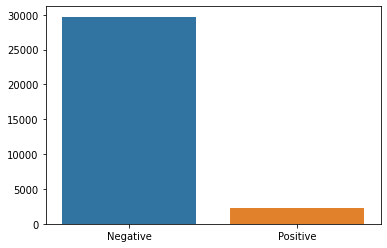

In [44]:
labels = ['Negative','Positive']
c = [z,o]
sns.barplot(x=labels,y=c)

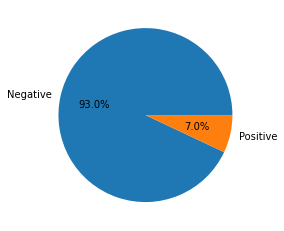

In [45]:
plt.pie(c,labels=labels,autopct='%1.1f%%')
plt.show()

### LSTM

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.3)

In [78]:
X_train.shape

(22373, 38236)

In [48]:
X_test.shape

(9589, 38236)

In [49]:
y_train.shape

(22373, 1)

In [50]:
y_train.shape

(22373, 1)

In [79]:
X_train1 = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_test1 = np.reshape(X_test, (X_test.shape[0],X_train.shape[1],1))
y_train1 = np.reshape(y_train, (y_train.shape[0],y_train.shape[1],1))
y_test1 = np.reshape(y_test, (y_test.shape[0],y_train.shape[1],1))

In [80]:
X_train1 = X_train1.astype('float32')
X_test1 = X_test1.astype('float32')

In [53]:
X_train1.shape

(22373, 38236, 1)

In [54]:
y_train1.shape

(22373, 1, 1)

In [102]:
model = Sequential()

model.add(Embedding(60, 64))
model.add(LSTM(units=50,dropout=0.3))
model.add(Dense(1))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 64)          3840      
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2         
Total params: 26,893
Trainable params: 26,893
Non-trainable params: 0
_________________________________________________________________


In [103]:
hist = model.fit(X_train1,y_train1,batch_size=64,epochs=1,validation_data=(X_test1,y_test1))

350/350 [==============================] - 1590s 5s/step - loss: 0.2994 - accuracy: 0.9273 - val_loss: 0.2443 - val_accuracy: 0.9336


In [104]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

300/300 [==============================] - 486s 2s/step - loss: 0.2443 - accuracy: 0.9336
Test Score: 0.24433141946792603
Test Accuracy: 0.9335697293281555


### Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb=MultinomialNB()
nb.fit(X_train,np.ravel(y_train))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
x1.shape

(31962, 38236)

In [ ]:
test1.shape

(17197, 25646)

In [ ]:
y_pred = nb.predict(X_test)

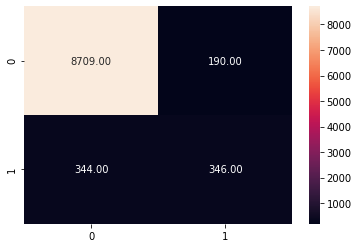

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_predict_test = y_pred
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='.2f')

In [ ]:
from sklearn.metrics import accuracy_score
ac = accuracy_score(y_test,y_pred)
ac

0.9443111899050995

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,np.ravel(y_train))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = rf.predict(X_test)

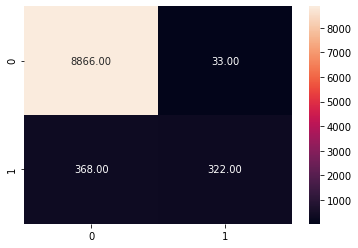

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
cm_rf = confusion_matrix(y_test,y_pred)
sns.heatmap(cm_rf,annot=True,fmt='.2f')

In [ ]:
from sklearn.metrics import accuracy_score
ac_rf = accuracy_score(y_test,y_pred)
ac_rf

0.9581812493482115